# Section 2 SciPy: Python tools for science
*Monica Rizzo, 2021*

SciPy is one of many Python packages that has a lot of useful tools for data analysis. Specifically, it was designed with STEM applications in mind, so most of its modules are for performing mathematical operations.  In this notebook we're going to be going over some of the functions in Scipy you can use to fit and model data. This is not at all an exhaustive tutorial though, so feel free to explore all of the different uses of SciPy on your own.

First things first, lets import all of the important stuff.

In [72]:
pip install sympy

In [76]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.optimize import brentq

from scipy.integrate import quad
from sympy import symbols, diff, lambdify
import sympy as sp

import matplotlib.pyplot as plt


#this makes the plot labels bigger (looks nicer)
plt.rcParams.update({'font.size': 18})

## 2.1 Functions: A Review

Way back in Module 2, you learned about Python functions, and went over how to define your own. In order to use some of SciPy's curve fitting tools, you will need to define functions for it to fit. So let's briefly review what goes into building a Python function, and how you can turn a math function into a Python function.

A quadratic function has the form:

\begin{equation*}f(x) = y = a x^2 + b x + c \end{equation*}
    
As a Python function, we would write this as:

In [2]:
def function(x, a, b, c):

    y = a * x**2 + b * x + c

    return y

In math classes, you may have talked about functions in terms of independent and dependent variables. In this example, we could call 'x' the independent variable and 'y' the dependent variable. Then 'a', 'b', and 'c' are what we would call **parameters** - these are values you can adjust to change the shape of the function. In this notebook, we'll be looking at how you can tune the parameters of a user-defined function to reproduce the shape of an arbitrary data set.


You can write a Python function to accept any number of parameters and variables, but for the following examples, we'll be looking at cases where there is only one set of independent variables (a single array) and multiple parameters. Keep in mind that the order of variables and parameters matters - when you define your function, write it to take **variables first, then parameters**.

## 2.2 Regression

There are a lot of things you can do with data. Often times, we will want to either 1) see how well data agrees with a given model or 2) without assuming anything, see what sort of model agrees the best with some data.
One way to test this is by using regression techniques. "Regression" is just the math word for fitting data to a certain function. You may have done something similar to this before with Excel, or by hand using graph paper.

Lucky for us, SciPy can quickly and easily fit things for you. First, lets generate some data that follows a known function - a straight line $$y = mx + b$$
1. **Using numpy, create an array of n equally spaced x values within some range - doesn't really matter what range**
2. **Then, plot a straight line, choosing your own values for the slope `m` and y-intercept `b`.**
3. **Finally, using your x array from 1 and your formula from 2, create a numpy array of y values.**

In [9]:
#create a numpy array of x values
#keep n relatively small (~10-20)
x_values = np.linspace(0, 100, 10)

#make an array of y values that follow the equation of a line
y_values = x_values**0.5

Now let's plot the data to see what it looks like (always a good first step).
1. **Make a scatter plot of the x and y values you created above**

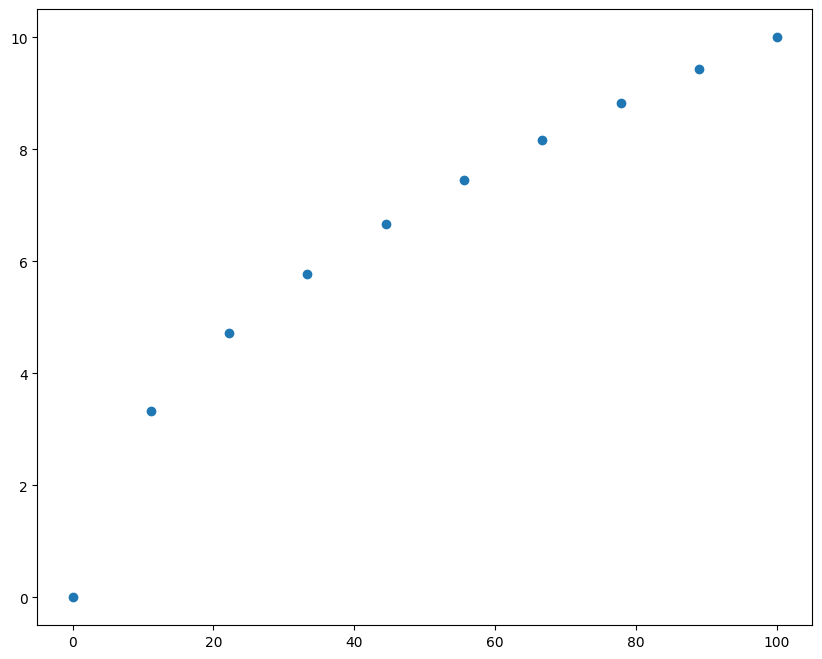

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(x_values,y_values)

The Scipy function we are going to use to do the fitting is called *curve_fit*. Given a user-defined Python function that describes the fit (in this case a line), *curve_fit* will attempt to find the best fitting parameters for some input data. So, in this case, we want to create a function that returns y-values corresponding to a line, and takes x-values and 2 free parameters: the slope and the y intercept. Then, we want to hand *curve_fit* that fit-function, the x data, and the y data, and it's going to tell us what it thinks the best fitting parameters are, along with the uncertainties on those parameters (which we're not going to worry about right now).

1. **Define a function which takes as inputs x, m, and b, and returns the y values corresponding to a line**
2. **Pass *curve_fit* the name of your fit function, your x data, and your y data (see documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)**
3. **Print the result of *curve_fit* (note: result should be a 2 element array. The values are in the same order as the parameters of your fit-function)**

In [30]:
def linear_fit(x, m, b):
    return m * x + b

In [31]:
params, covariance = curve_fit(linear_fit, x_values, y_values)
params

array([0.08790012, 2.04032774])

Nice.

![Alt Text](https://media.giphy.com/media/XreQmk7ETCak0/giphy.gif)

Now let's look at a more realistic example. In real life, data is noisy and usually has some associated uncertainty. Lets add a little bit of noise to our existing data, and assign some uncertainty.

1. **Generate random values using *np.random.normal*, and add those values to your array of y values (documentation here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)**
2. **Create an array - which will be your y-error - of length n where all of the values are the same as what you set the 'scale' option to in *np.random.normal***

In [32]:
scale_value = 1.5
y_noise = np.random.normal(loc=0, scale=scale_value, size=len(y_values))
y_values_noisy = y_values + y_noise
y_error = np.full(len(y_values), scale_value)

Now, let's plot the data again. In order to plot the errors, instead of using the 'plot' function, use 'errorbar': https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.errorbar.html

Text(0.5, 1.0, 'Noisy Data')

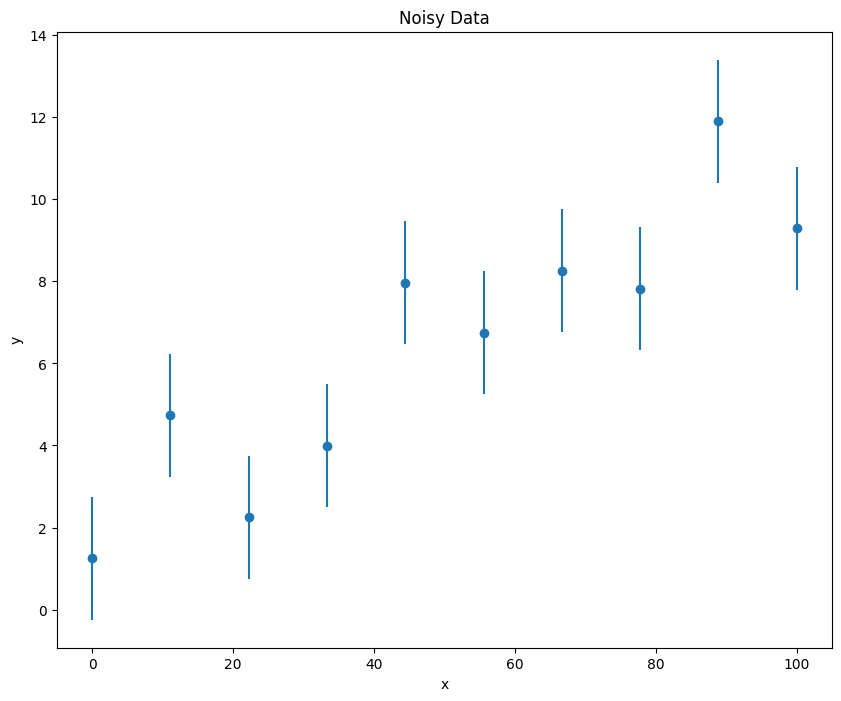

In [34]:
plt.figure(figsize=(10, 8))
#try using fmt='o' and markersize=6.0
plt.errorbar(x_values, y_values_noisy, yerr=y_error, fmt='o', markersize=6.0)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy Data')

Not so pretty anymore, but maybe still looks like a line? The larger you make the 'scale' option in *np.random.normal*, the more noisy the data will look. You can try upping the value to make the data noisier if it's not significantly noisy already. Then, let's see what SciPy thinks.

1. **Using the same syntax as before, pass *curve_fit* the same fit-function and x data, your noisy y data, and also the uncertainty on your y values - this can be done using the 'sigma' option.**
2. **As before, print the result**

In [35]:
#use curve fit to find the fit parameters for your noisy data
result, cov = curve_fit(linear_fit, x_values, y_values_noisy, sigma=y_error)

#print the results
print(result)

[0.08827646 2.00705018]


You may find that this answer is pretty different from the actual values of the parameters. We can plot what the fit looks like over our data to visually assess how bad/good it is.

1. **Create a numpy array of test x values that has a slightly larger range, and more points than your original x values**
2. **Pass this array, along with the best fit m and b values, to your fit function, and store the result as a separate array**
3. **Copy the cell you used to plot the data with errorbars, and add a line to plot the new x values and predicted y values**

In [36]:
#array of x test values
x_test_values = np.linspace(0, 100, 100)

#array of y test values
y_test_values = fit_function(x_test_values, result[0], result[1])

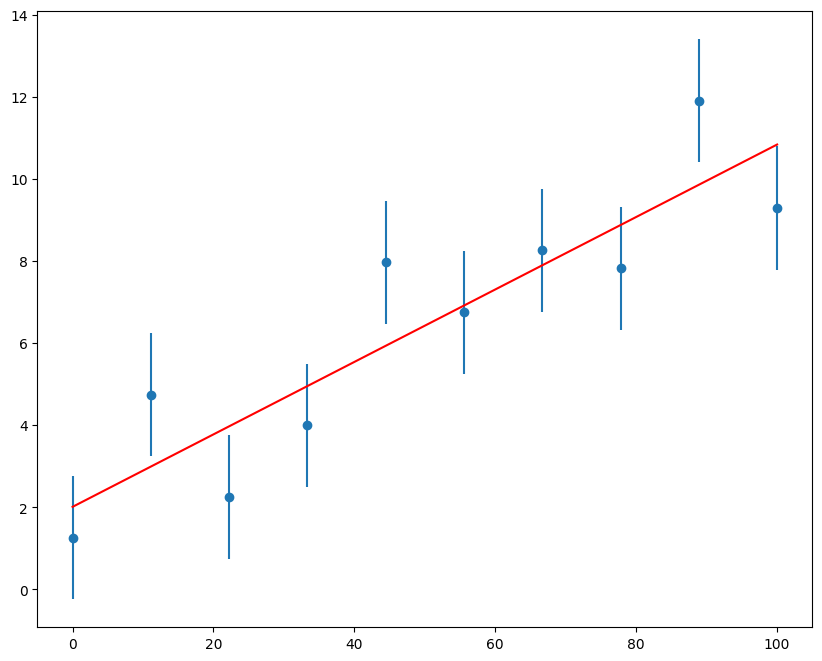

In [37]:
plt.figure(figsize=(10, 8))
plt.errorbar(x_values, y_values_noisy, yerr=y_error, fmt='o', markersize=6.0)
plt.plot(x_test_values, y_test_values, color='red')

Keep in mind that these answers are just predictions - they also have some uncertainty to them. The other thing that *curve_fit* returns - which we're calling *cov* - describes the uncertainites on the fit parameters. Let's see what those look like.

In [38]:
#cov is a matrix, and we only want the diagonal values
#here, we're taking the square root of the diagonal values, which are the standard deviation squared
unc = np.sqrt(np.diag(cov))

print("param1_err =",unc[0],"param2_err =", unc[1])

param1_err = 0.015468057936352897 param2_err = 0.9175203544965932


**Given what your data looks like, do you think these numbers are reasonable? Do your fit parameters to the noisy data agree with the real parameters within this uncertainty?**

In [39]:
# This is pretty reasonable. These values align with the data as the error bars are quite large for this data

## 2.3 Interpolation

Now let's switch gears a little bit. Suppose we have some data where instead of function parameters (slopes, y-intercepts, etc.), we want to approximate what the values between our data points are. So in this case, we don't care about the specifics of the fit, we just want to connect the dots. This can be achieved using *interpolation* techniques.

First, lets again create some data that follows a known function:
1. **Using numpy arrays, create an array of 8 x values that ranges from 0 to 2$\pi$**
2. **Create an array of y values which is the sine of the x values**

In [40]:
#array of x values
x_values = np.linspace(0, 2*np.pi, 8)

#array of y values
y_values = np.sin(x_values)

As per *always*, make a scatter plot of your data before doing anything else.

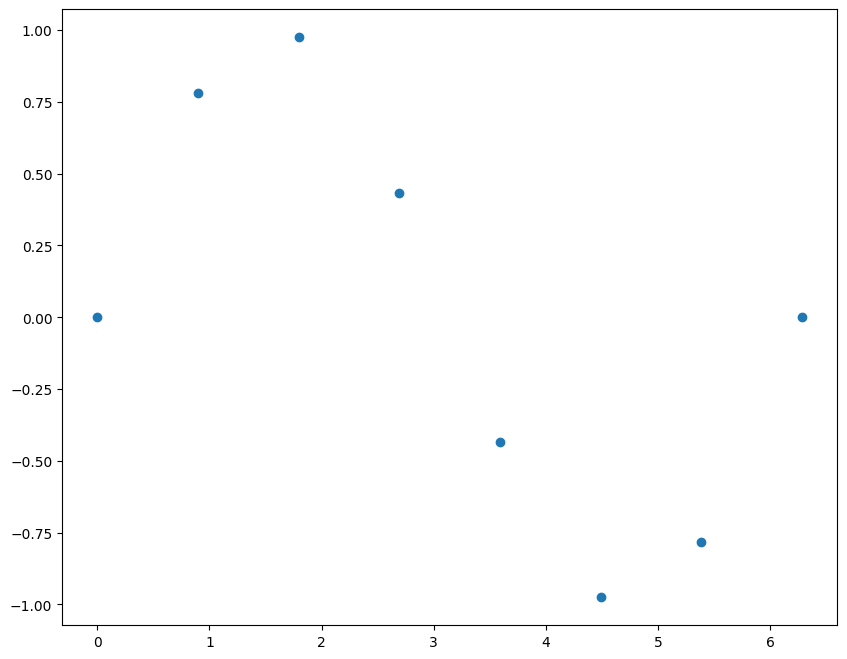

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)

This could be sine curve - and I'm sure if you connected the dots by hand you would draw something that resembles a sine function. But let's see how well we can approximate this by numerically interpolating. To start, let's use the default settings of *interp_1d*. When passed x and y values, *interp_1d* will return a function which interpolates the data at every point between the maximum and minimum x value. We can then plot the values of this interpolation function over a range of test x values.

1. **Pass *interp1d* your x and y values (see documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)**
2. **Create an array of 500 n test x values between 0 and 2$\pi$**
3. **Pass your interpolation function your array of test x values and store the result as test y values**
4. **Plot your test values as a line over a scatter plot of your data**

In [42]:
#create an interpolation function
interp_func = interp1d(x_values, y_values)

#array of test x values
x_test_values = np.linspace(0, 2*np.pi, 500)

#recall that interp_func is a function, so it can be used like any other function
y_test_values = interp_func(x_test_values)

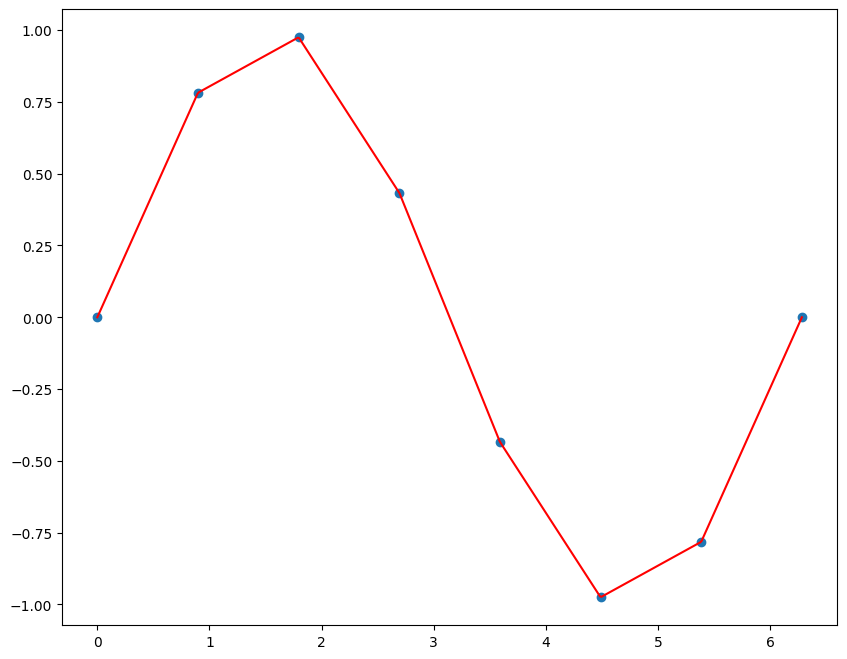

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)
plt.plot(x_test_values, y_test_values, color='red')

As you can see, *interp_1d* connects the data points with straight lines by default. This isn't always the best way to interpolate data; based on how we generated it, we already know that our data has some curvature to it. It's also generally better to interpolate data smoothly, because this makes performing operations like differentiation easier/more accurate. Lets try out some different types of interpolation.

To change the way *interp_1d* connects our data points, we can use the 'kind' option. By default this option is 'linear'.
1. **Try setting 'kind' to each of the following: 'zero', 'quadratic', 'cubic'. For each different kind, create a new variable name to store the interpolating function in.**
2. **Using the same method as above, plot the data and the interpolated approximation on top of each other. You can use the same test x values, but will need to create new test y values for each plot**

In [44]:
interp_func_zero = interp1d(x_values, y_values, kind='zero')
interp_func_quadratic = interp1d(x_values, y_values, kind='quadratic')
interp_func_cubic = interp1d(x_values, y_values, kind='cubic')

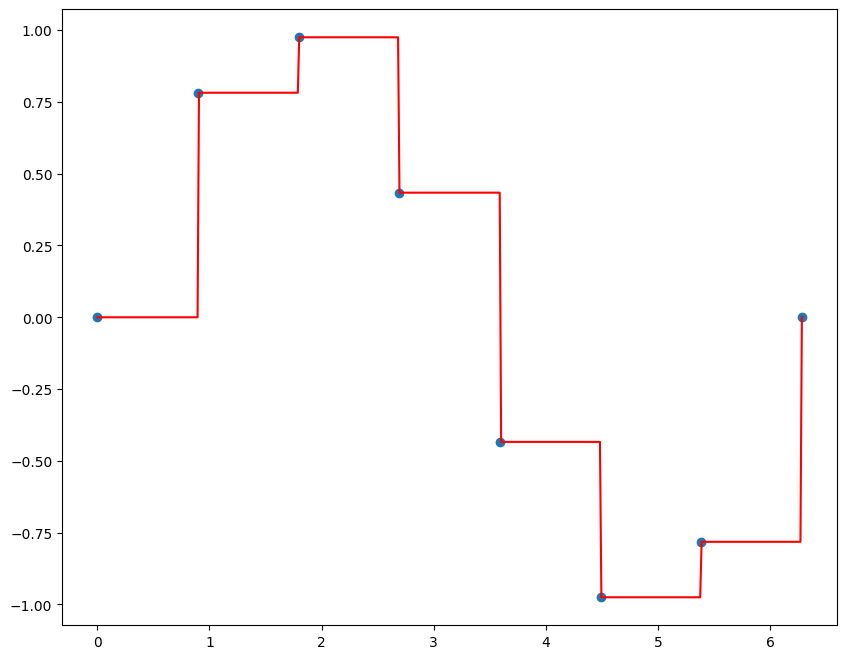

In [45]:
#test y values
y_test_values = interp_func_zero(x_test_values)
#zero plot
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)
plt.plot(x_test_values, y_test_values, color='red')

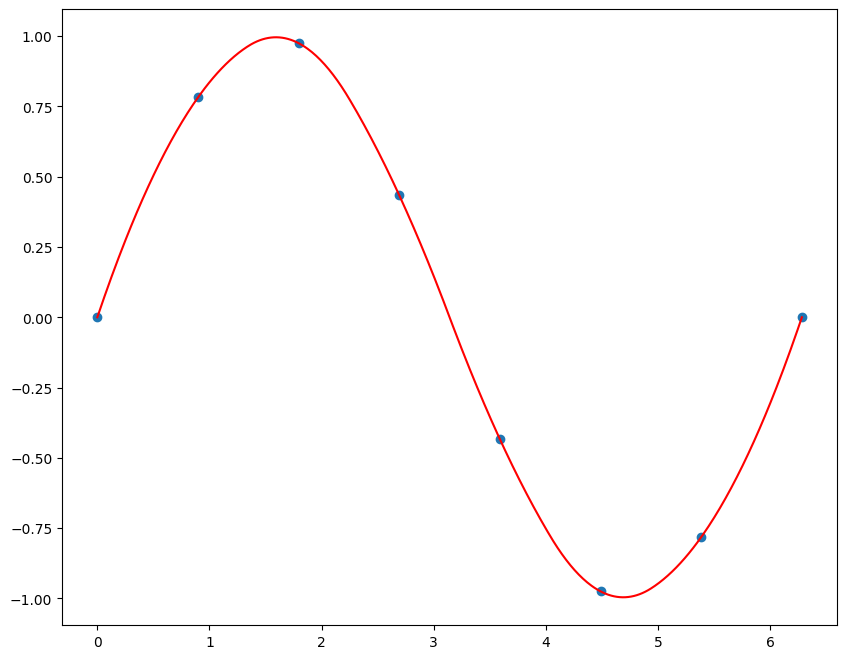

In [46]:
#test y values
y_test_values_quadratic = interp_func_quadratic(x_test_values)
y_test_values_cubic = interp_func_cubic(x_test_values)
#quadratic plot
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)
plt.plot(x_test_values, y_test_values_quadratic, color='red')

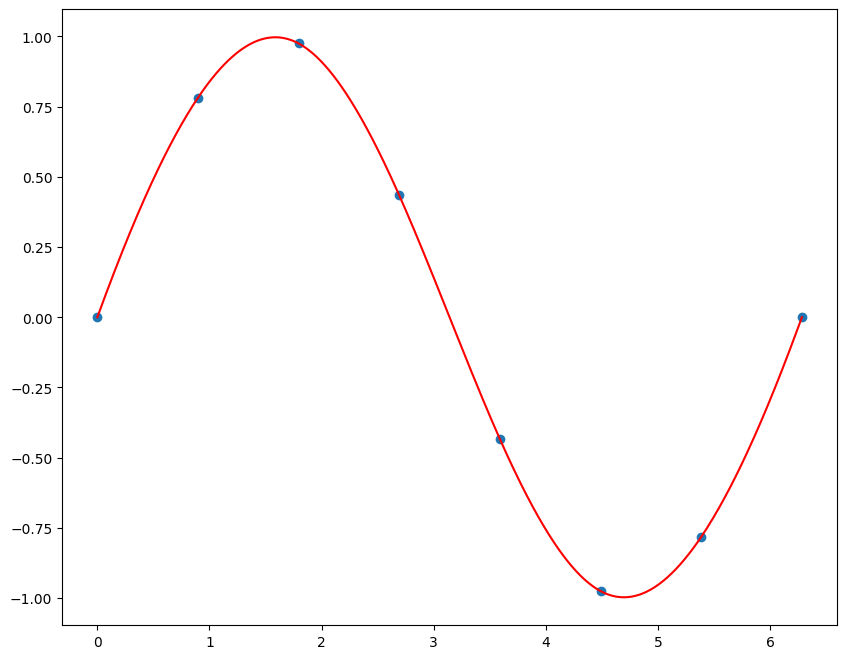

In [47]:
#test y values
y_test_values_quadratic = interp_func_quadratic(x_test_values)
y_test_values_cubic = interp_func_cubic(x_test_values)
#cubic plot
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)
plt.plot(x_test_values, y_test_values_cubic, color='red')

How can we judge which of these kinds of interpolation is the best? We know what the values of the function *should* be, so we can compute the average uncertainty using something called the root-mean-square deviation (RMSD). This follows the formula:

\begin{equation*}RMSD = \sqrt{\frac{\sum (y_{real} - y_{model})^2}{N}} \end{equation*}


Here, the model values will be the values predicted by the interpolating functions, and N will be the number of points in these arrays (should be 500). In the cell below, check to see how different each of the approximate y values are from the real values.

1. **To generate an array of true y values, take the sine of your test x values**
2. **For each of the interpolation functions, compute and store in different variables the RMSD**
3. **Print each of the RMSD values, along with the interpolation method they correspond to**

*Hint: compute the sum using np.sum()

In [49]:
#real y values
y_real_value = np.sin(x_test_values)


rmsd_value_linear = (np.sum((y_real_value - y_test_values)**2)/500)**0.5

#repeat for all interpolation functions
rmsd_value_quad = (np.sum((y_real_value - y_test_values_quadratic)**2)/500)**0.5
rmsd_value_cubic = (np.sum((y_real_value - y_test_values_cubic)**2)/500)**0.5

print("RMSD for linear interpolation:", rmsd_value_linear)
print("RMSD for quadratic interpolation:", rmsd_value_quad)
print("RMSD for cubic interpolation:", rmsd_value_cubic)

RMSD for linear interpolation: 0.3587751576531893
RMSD for quadratic interpolation: 0.011545510711241113
RMSD for cubic interpolation: 0.005870509635367449


Based on this, which appears to be the best kind of interpolation? This happens to be the best kind in general (and my favorite interpolation method :)).

*Optional*: We can also check to make sure the area under the curve is what we expect it to be. For a sine curve in the range 0 to 2$\pi$, the total area should be zero - this is because half the the curve is above zero and half is below. In order to find the area under the curve, we can *integrate* it - SciPy also has functions to do this. The particular algorithm we're going to use is called *quad* (which is all around the most accurate in SciPy). *quad* takes as arguments the name of the function you want to integrate, the upper bound of the integration, and the lower bound of the integration.

1. **For each of the interpolation functions, use quad to integrate from 0 to 2$\pi$ (see documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad)**
2. **Print out the result of each. Why do you think the results are what they are?**

*Note: when doing things computationally, numbers smaller than or close to $10^{-16}$ are considered zero*

In [ ]:
res_linear, err = quad(


## 2.4 Root Finding

Now let's talk - briefly - about something completely different. In math classes, you may have needed to find the zeros of functions before (set y equal to zero and solve for x). Finding zeros is very important in the area of numerical optimization - which we won't talk about explicity - but can often be more complicated than just setting y equal to zero and solving for x. In fact, when you have no functional form and just data points, you can't do this at all.

And that's where SciPy comes in. Suppose we have some interpolating function which passes through zero, and we want to know approximately where. One of the best algorithms to do this is something called *Brent's method*. *Brent's method* will attempt to find where a function crosses zero in a given interval; it needs to know the endpoints to look between in order to work.

First, lets create some data to try this out on:
1. **Using numpy, create an array of 10 equally spaced x values between -2 and 2**
2. **Create an array of y values that is the x values cubed plus 3**

In [50]:
#array of x values
x_values = np.linspace(-2, 2, 10)
#array of y values
y_values = x_values**3 + 3

Plot your data.

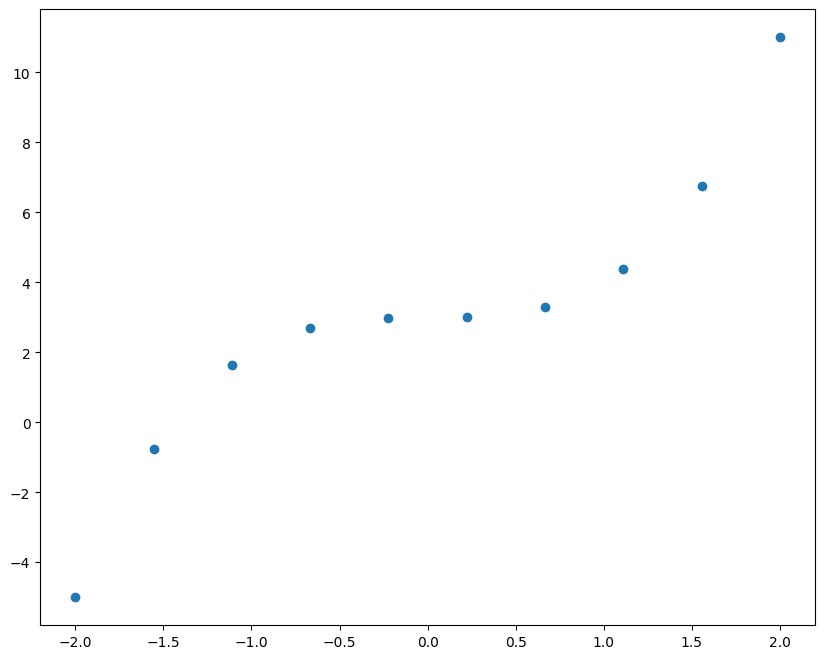

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values)

Based on the plot, at what x value do you expect the zero point to be?

Let's see what SciPy thinks. We're going to use a function called *brentq*. This function takes the name of the function you want the zero of, the upper bound of that function, and the lower bound of that function. So first, we need to interpolate the data, and then pass that interpolant to *brentq*.

1. **Using the best interpolation kind from the previous section, create and store an interpolating function of your x and y data**
2. **Pass *brentq* the name of your interpolating function, the lower bound of the function, and the upper bound of the function (see documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq)**
3. **Print the result. Does this answer seem correct?**

In [52]:
interp_func_cubic = interp1d(x_values, y_values, kind='cubic')

zero_point = brentq(interp_func_cubic, x_values.min(), x_values.max())

print("Approximate zero point:", zero_point)

expected_zero = (-3)**(1/3)
print("Expected zero point:", expected_zero)

# The answer seems correct as the calculated zero is very close to the expected value.

Approximate zero point: -1.4422495703073985
Expected zero point: (0.7211247851537043+1.2490247664834064j)


## 2.5 Fun With Real Data

Now let's tackle a (sort of) real-life example. Using the provided data file, we will attempt to fit the data it contains with a more complicated fit function. First, we will load and plot the data.

1. **Use numpy to load the data and plot it (with error bars)**

In [53]:
# Run this cell if using Colab
!wget https://raw.githubusercontent.com/CIERA-Northwestern/REACHpy/main/Module_4/data/scipy_data.txt

--2025-06-11 01:44:22--  https://raw.githubusercontent.com/CIERA-Northwestern/REACHpy/main/Module_4/data/scipy_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 675 [text/plain]
Saving to: ‘scipy_data.txt’

scipy_data.txt      100%[===================>]     675  --.-KB/s    in 0s      

2025-06-11 01:44:22 (35.4 MB/s) - ‘scipy_data.txt’ saved [675/675]



In [55]:
#load data and store it to an array
#columns: x values, y values, y error
data = np.loadtxt('scipy_data.txt')
#split the data into separate x, y, and y_err arrays using numpy array slicing
x_values = data[:,0]
y_values = data[:,1]
y_error = data[:,2]

Text(0.5, 1.0, 'Real Data')

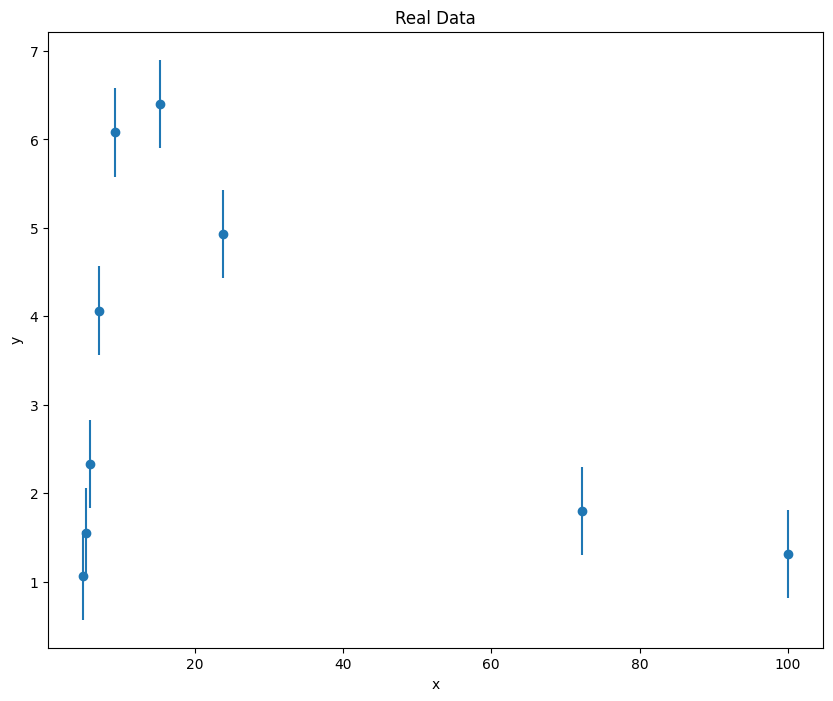

In [56]:
#plot. that. data
plt.figure(figsize=(10, 8))
plt.errorbar(x_values, y_values, yerr=y_error, fmt='o', markersize=6.0)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real Data')

What do you think this function looks like? Using your knowledge of regression, try to think of a fitting function which might model this data, and then fit that model to the data.

1. **Define a fitting function, and fit it to the data using *curve_fit***
2. **Print the best fit parameters and their uncertainties**
3. **Plot the data and the fit on top of each other**

*Hint: try to fit a higher order polynomial*

Best fit parameters:
p0: 0.0001 ± 0.0000
p1: -0.0113 ± 0.0014
p2: 0.4999 ± 0.0607
p3: 0.1518 ± 0.4788


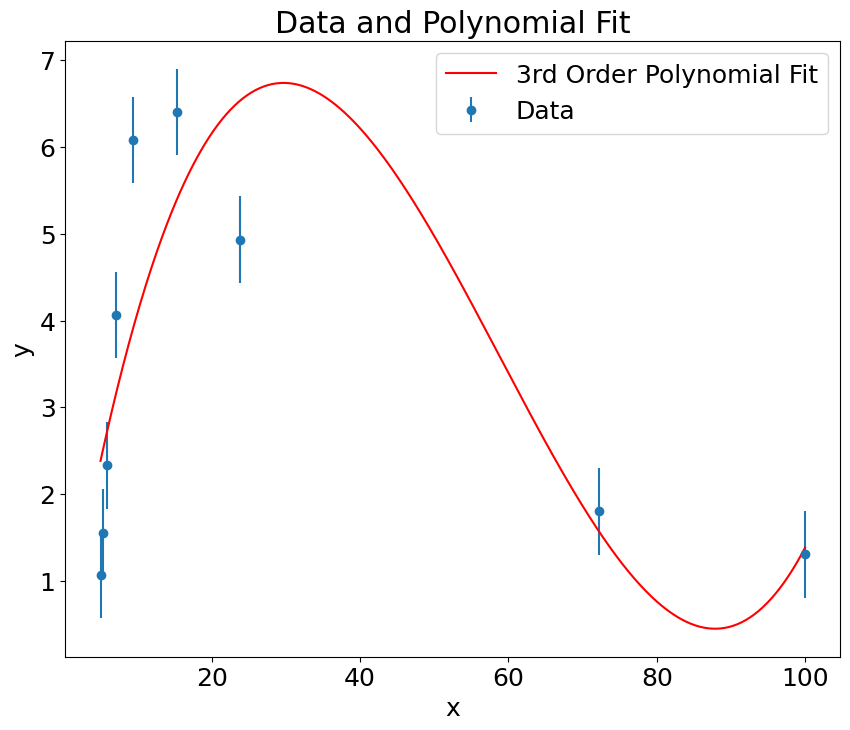

In [82]:
def poly3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

params, covariance = curve_fit(poly3, x_values, y_values, sigma=y_error, absolute_sigma=True)
param_errors = np.sqrt(np.diag(covariance))

print("Best fit parameters:")
for i, (p, e) in enumerate(zip(params, param_errors)):
    print(f"p{i}: {p:.4f} ± {e:.4f}")

# Generate a smooth line for the fit
x_fit = np.linspace(min(x_values), max(x_values), 500)
y_fit = poly3(x_fit, *params)

# Plot the data and the fit
plt.figure(figsize=(10, 8))
plt.errorbar(x_values, y_values, yerr=y_error, fmt='o', markersize=6.0, label='Data')
plt.plot(x_fit, y_fit, 'r-', label='3rd Order Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data and Polynomial Fit')
plt.legend()

**How well does your fit function look like it fits the data? If you want, try a different function and see if it fits better.**

This data - which represents part of the spectrum (units of flux vs. frequency) from an astophysical object - has a particular function that best fits it. In order to fit that function we're going to cheat a little and find the location of the peak, i.e. where the slope of the function equals zero. To do this, we need to first interpolate our data, and then find where the slope (or *derivative*) equals zero.

1. **Interpolate the data using the best kind of interpolation**
2. **Define a function that takes x values and returns the derivative of your interpolation function at those x values (already completed for you)**
3. **Pass the derivative function to *brentq* (remember you need to pass it a lower and upper bound), and store the result. Print this result. Does it make sense?**

Peak found at x = 12.2579, y = 6.8011


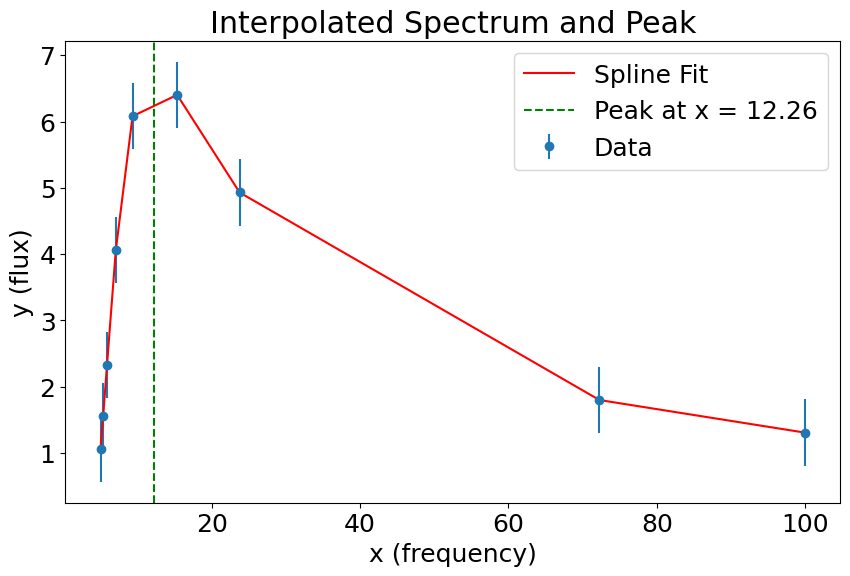

In [83]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import brentq

spline = UnivariateSpline(x_values, y_values, w=1/y_error, s=0)

# Define derivative function
def derivative(x):
    return spline.derivative()(x)

# Estimate interval for peak (adjust if needed)
peak_x = brentq(derivative, 5, 15)
peak_y = spline(peak_x)

# Print result
print(f"Peak found at x = {peak_x:.4f}, y = {peak_y:.4f}")

# Plot data and spline fit
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, yerr=y_error, fmt='o', label='Data')
plt.plot(x_values, spline(x_values), 'r-', label='Spline Fit')
plt.axvline(peak_x, color='green', linestyle='--', label=f'Peak at x = {peak_x:.2f}')
plt.xlabel('x (frequency)')
plt.ylabel('y (flux)')
plt.title('Interpolated Spectrum and Peak')
plt.legend()

The function we want to fit to is something called a broken power law:

\begin{equation}f(x) = a ((x/x0)^{b1/-0.8} + (x/x0)^{b2/-0.8})^{-0.8},\end{equation}

where a, b1, and b2 are the three fit parameters. Now that we know x0, we can use *curve_fit* to find the remaining 3 parameters.

1. **Define a function called 'broken_power_law' which takes x values, a, b1, and b2 as input and returns the values corresponding to the above expression**
2. **Use *curve_fit* to fit this function to the data, *including the uncertainties on y*. Print the result and uncertainties**
3. **Plot the data and the fit on top of each other. Would you say this fit is good or bad? Why or why not?**

In [86]:
x0 = brentq(derivative, 5, 15)
print(f"Peak (x0) found at: {x0:.4f}")

def broken_power_law(x, a, b1, b2):
    term1 = (x / x0)**b1
    term2 = (x / x0)**b2
    return a * (term1 / -0.8 + term2 / -0.8)**(-0.8)


Peak (x0) found at: 12.2579


In [87]:
popt, pcov = curve_fit(broken_power_law, x_values, y_values, sigma=y_error, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

print("\nFit parameters:")
print(f"a   = {popt[0]:.4f} ± {perr[0]:.4f}")
print(f"b1  = {popt[1]:.4f} ± {perr[1]:.4f}")
print(f"b2  = {popt[2]:.4f} ± {perr[2]:.4f}")


Fit parameters:
a   = 1.0000 ± inf
b1  = 1.0000 ± inf
b2  = 1.0000 ± inf


<ipython-input-86-1597261551>:7: RuntimeWarning: invalid value encountered in power
  return a * (term1 / -0.8 + term2 / -0.8)**(-0.8)
<ipython-input-87-462171285>:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(broken_power_law, x_values, y_values, sigma=y_error, absolute_sigma=True)


<ipython-input-86-1597261551>:7: RuntimeWarning: invalid value encountered in power
  return a * (term1 / -0.8 + term2 / -0.8)**(-0.8)


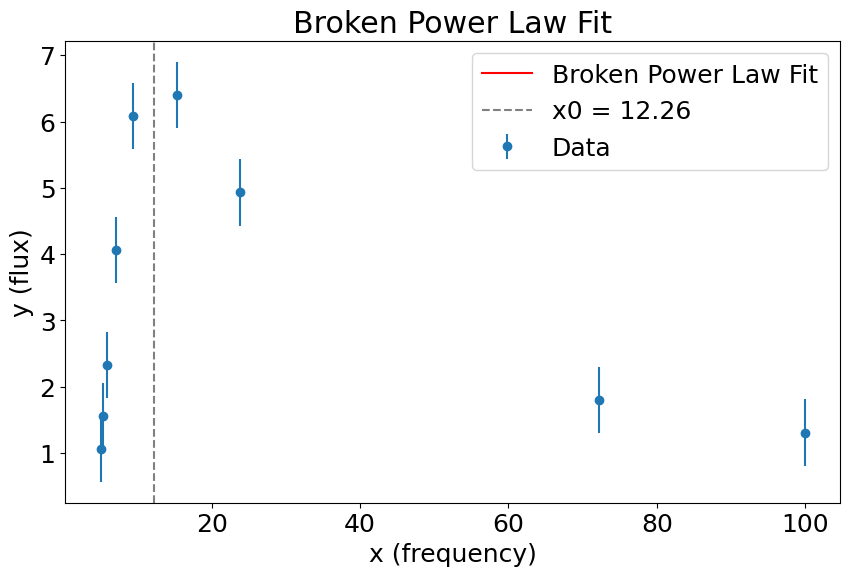

In [88]:
x_fit = np.linspace(min(x_values), max(x_values), 500)
y_fit = broken_power_law(x_fit, *popt)

plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, yerr=y_error, fmt='o', label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Broken Power Law Fit')
plt.axvline(x0, color='gray', linestyle='--', label=f'x0 = {x0:.2f}')
plt.xlabel('x (frequency)')
plt.ylabel('y (flux)')
plt.title('Broken Power Law Fit')
plt.legend()

## More Fun Stuff: Bonus

As far as cool and useful tools go, SciPy has a *ton* of other nifty functions (with decent documentation), for almost every application. The data above is from a course I took on radiative processes in astrophysics. You can learn various things about the object which produced this light curve by finding the slope of each side of the logarithm of the data. This is just one idea of something you can do with this data besides just fitting it.   

See what else you can do with it!

Some ideas:

* try a different fitting function
* interpolate the data
* find the point where the slope of the data is zero
* integrate/differentiate the data

In [ ]:
##play around with the data and see what you can do with it
##if you need help or suggestions, don't hesitate to ask!










## Resources

A set of SciPy tutorials and documentation can be found here: https://docs.scipy.org/doc/scipy/reference/index.html

The Scipy Lectures site also has a pretty comprehensive guide to all of the modules: https://scipy-lectures.org/intro/scipy.html

Here is a nifty explanation of the difference between regression and interpolation (which I found useful): https://stats.stackexchange.com/questions/33659/how-is-interpolation-related-to-the-concept-of-regression

Here is a lecture (which is honestly pretty heavy, but if you want to look through it you can) on numerical root finding methods: http://butler.cc.tut.fi/~piche/numa/lecture0506.pdf
